# Classification with KerasHub

**Author:** [Gowtham Paimagam](https://github.com/gowthamkpr)<br>
**Date created:** 09/24/2024<br>
**Last modified:** 10/04/2024<br>
**Description:** Use KerasHub to train powerful image classifiers.

Classification is the process of predicting a categorical label for a given
input image.
While classification is a relatively straightforward computer vision task,
modern approaches still are built of several complex components.
Luckily, Keras provides APIs to construct commonly used components.

This guide demonstrates Keras' modular approach to solving image
classification problems at three levels of complexity:

- Inference with a pretrained classifier
- Fine-tuning a pretrained backbone
- Training a image classifier from scratch

KerasHub uses Keras 3 to work with any of TensorFlow, PyTorch or Jax. In the
guide below, we will use the `jax` backend. This guide runs in
TensorFlow or PyTorch backends with zero changes, simply update the
`KERAS_BACKEND` below.

We use Professor Keras, the official Keras mascot, as a
visual reference for the complexity of the material:

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_evolution.png)

In [ ]:
!pip install -q git+https://github.com/keras-team/keras-hub.git
!pip install -q --upgrade keras  # Upgrade to Keras 3.

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.3 MB/s eta 0:00:00


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds


## Inference with a pretrained classifier

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_beginner.png)

Let's get started with the simplest KerasHub API: a pretrained classifier.
In this example, we will construct a classifier that was
pretrained on the ImageNet dataset.
We'll use this model to solve the age old "Cat or Dog" problem.

The highest level module in KerasHub is a *task*. A *task* is a `keras.Model`
consisting of a (generally pretrained) backbone model and task-specific layers.
Here's an example using `keras_hub.models.ImageClassifier` with an
ResNet Backbone.

ResNet is a great starting model when constructing an image
classification pipeline.
This architecture manages to achieve high accuracy, while using a
compact parameter count.
If a ResNet is not powerful enough for the task you are hoping to
solve, be sure to check out [KerasHub's other available Backbones](https://github.com/keras-team/keras-hub/tree/master/keras_hub/src/models)!

In [ ]:
classifier = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet"
)

100%|██████████| 840/840 [00:00<00:00, 753kB/s]


100%|██████████| 3.42k/3.42k [00:00<00:00, 4.00MB/s]


100%|██████████| 98.1M/98.1M [00:06<00:00, 16.4MB/s]


100%|██████████| 90.2M/90.2M [00:06<00:00, 15.3MB/s]


You may notice a small deviation from the old `keras.applications` API; where
you would construct the class with `Resnet50V2(weights="imagenet")`.
While the old API was great for classification, it did not scale effectively to
other use cases that required complex architectures, like object detection and
semantic segmentation.

We first create a utility function for plotting images throughout this tutorial:

In [ ]:
def plot_image_gallery(images, titles=None, n_cols=3, figsize=(6, 12)):
    n_images = len(images)
    images = np.asarray(images) / 255.0
    images = np.minimum(np.maximum(images, 0.0), 1.0)
    n_rows = (n_images + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten in case the axes is a 2D array

    for i, ax in enumerate(axes):
        if i < n_images:
            # Plot the image
            ax.imshow(images[i])
            ax.axis('off')  # Remove axis
            if titles and len(titles) > i:
                ax.set_title(titles[i], fontsize=12)
        else:
            # Turn off the axis for any empty subplot
            ax.axis('off')

    plt.show()
    plt.close()


Now that our classifier is built, let's apply it to this cute cat picture!

309830/309830 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


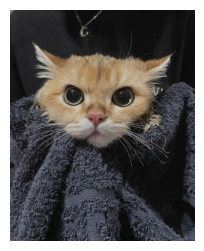

In [ ]:
filepath = keras.utils.get_file(origin="https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/5hR96puA_VA.jpg/1024px-5hR96puA_VA.jpg")    #changed this as the existing link doesn't work
image = keras.utils.load_img(filepath)
image = np.array(image)
plot_image_gallery(
    np.array([image]), n_cols=1, figsize=(3,3)
)

Next, let's get some predictions from our classifier:

In [ ]:
predictions = classifier.predict(np.expand_dims(image, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Predictions come in the form of softmax-ed category rankings.
We can find the index of the top classes using a simple argsort function:

In [ ]:
top_classes = predictions[0].argsort(axis=-1)


In order to decode the class mappings, we can construct a mapping from
category indices to ImageNet class names.
For convenience, I've stored the ImageNet class mapping in a GitHub gist.
Let's download and load it now.

In [ ]:
classes = keras.utils.get_file(
    origin="https://gist.githubusercontent.com/LukeWood/62eebcd5c5c4a4d0e0b7845780f76d55/raw/fde63e5e4c09e2fa0a3436680f436bdcb8325aac/ImagenetClassnames.json"
)
with open(classes, "rb") as f:
    classes = json.load(f)

33567/33567 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


Now we can simply look up the class names via index:

In [ ]:
top_two = [classes[str(i)] for i in top_classes[-2:]]
print("Top two classes are:", top_two)

Top two classes are: ['bath towel', 'Persian cat']


Great!  Both of these appear to be correct!
However, one of the classes is "Bath towel".
We're trying to classify Cats VS Dogs.
We don't care about the towel!

Ideally, we'd have a classifier that only performs computation to determine if
an image is a cat or a dog, and has all of its resources dedicated to this task.
This can be solved by fine tuning our own classifier.

## Fine tuning a pretrained classifier

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_intermediate.png)

When labeled images specific to our task are available, fine-tuning a custom
classifier can improve performance.
If we want to train a Cats vs Dogs Classifier, using explicitly labeled Cat vs
Dog data should perform better than the generic classifier!
For many tasks, no relevant pretrained model
will be available (e.g., categorizing images specific to your application).

First, let's get started by loading some data:

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


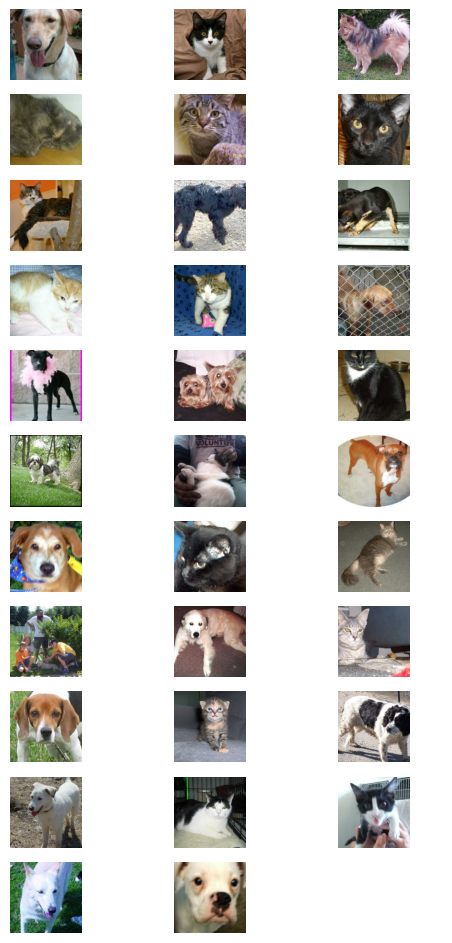

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
AUTOTUNE = tf.data.AUTOTUNE
tfds.disable_progress_bar()

data, dataset_info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_steps_per_epoch = dataset_info.splits["train"].num_examples // BATCH_SIZE
train_dataset = data["train"]

num_classes = dataset_info.features["label"].num_classes

resizing = keras.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)


def preprocess_inputs(image, label):
    image = tf.cast(image, tf.float32)
    # Staticly resize images as we only iterate the dataset once.
    return resizing(image), tf.one_hot(label, num_classes)


# Shuffle the dataset to increase diversity of batches.
# 10*BATCH_SIZE follows the assumption that bigger machines can handle bigger
# shuffle buffers.
train_dataset = train_dataset.shuffle(
    10 * BATCH_SIZE, reshuffle_each_iteration=True
).map(preprocess_inputs, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)

images = next(iter(train_dataset.take(1)))[0]
plot_image_gallery(images)

Meow!

Next let's construct our model.
The use of imagenet in the preset name indicates that the backbone was
pretrained on the ImageNet dataset.
Pretrained backbones extract more information from our labeled examples by
leveraging patterns extracted from potentially much larger datasets.

Next lets put together our classifier:

In [ ]:
model = keras_hub.models.ImageClassifier.from_preset(
    "resnet_v2_50_imagenet", num_classes=2
)
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.SGD(learning_rate=0.01),
    metrics=["accuracy"],
)

Here our classifier is just a simple `keras.Sequential`.
All that is left to do is call `model.fit()`:

In [ ]:
model.fit(train_dataset)


727/727 ━━━━━━━━━━━━━━━━━━━━ 251s 319ms/step - accuracy: 0.4593 - loss: 0.9827


Let's look at how our model performs after the fine tuning:

In [ ]:
predictions = model.predict(np.expand_dims(image, axis=0))

classes = {0: "cat", 1: "dog"}
print("Top class is:", classes[predictions[0].argmax()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Top class is: cat


Awesome - looks like the model correctly classified the image.

## Train a Classifier from Scratch

![](https://storage.googleapis.com/keras-nlp/getting_started_guide/prof_keras_advanced.png)

Now that we've gotten our hands dirty with classification, let's take on one
last task: training a classification model from scratch!
A standard benchmark for image classification is the ImageNet dataset, however
due to licensing constraints we will use the CalTech 101 image classification
dataset in this tutorial.
While we use the simpler CalTech 101 dataset in this guide, the same training
template may be used on ImageNet to achieve near state-of-the-art scores.

Let's start out by tackling data loading:

In [ ]:
BATCH_SIZE = 32
NUM_CLASSES = 101
IMAGE_SIZE = (224, 224)

# Change epochs to 100~ to fully train.
EPOCHS = 1


def package_inputs(image, label):
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


train_ds, eval_ds = tfds.load(
    "caltech101", split=["train", "test"], as_supervised="true"
)
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.shuffle(BATCH_SIZE * 16)
augmenters = []

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


The CalTech101 dataset has different sizes for every image, so we resize images before batching them using the
`batch()` API.

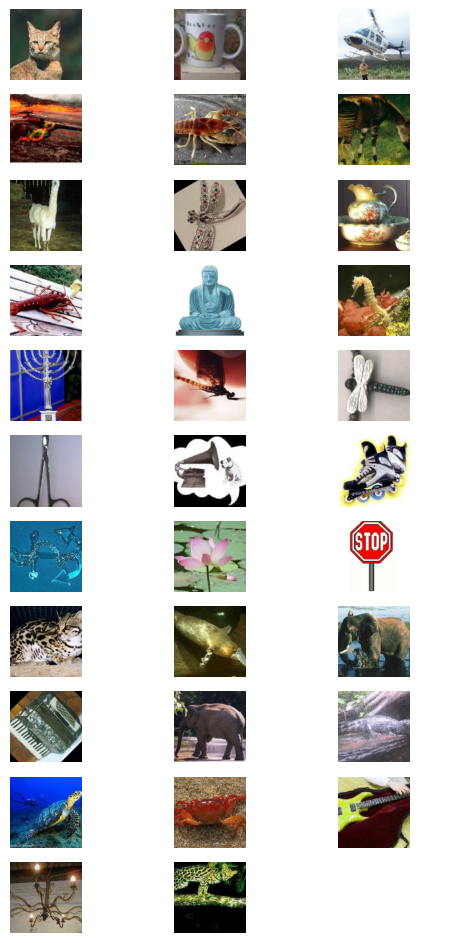

In [ ]:
resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
train_ds = train_ds.map(resize)
eval_ds = eval_ds.map(resize)

train_ds = train_ds.batch(BATCH_SIZE)
eval_ds = eval_ds.batch(BATCH_SIZE)

batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]
label_batch = batch["labels"]

plot_image_gallery(
    image_batch,
)

### Data Augmentation

In our previous finetuning example, we performed a static resizing operation and
did not utilize any image augmentation.
This is because a single pass over the training set was sufficient to achieve
decent results.
When training to solve a more difficult task, you'll want to include data
augmentation in your data pipeline.

Data augmentation is a technique to make your model robust to changes in input
data such as lighting, cropping, and orientation.
Keras includes some of the most useful augmentations in the `keras.layers`
API.
Creating an optimal pipeline of augmentations is an art, but in this section of
the guide we'll offer some tips on best practices for classification.

One caveat to be aware of with image data augmentation is that you must be careful
to not shift your augmented data distribution too far from the original data
distribution.
The goal is to prevent overfitting and increase generalization,
but samples that lie completely out of the data distribution simply add noise to
the training process.

The first augmentation we'll use is `RandomFlip`.
This augmentation behaves more or less how you'd expect: it either flips the
image or not.
While this augmentation is useful in CalTech101 and ImageNet, it should be noted
that it should not be used on tasks where the data distribution is not vertical
mirror invariant.
An example of a dataset where this occurs is MNIST hand written digits.
Flipping a `6` over the
vertical axis will make the digit appear more like a `7` than a `6`, but the
label will still show a `6`.

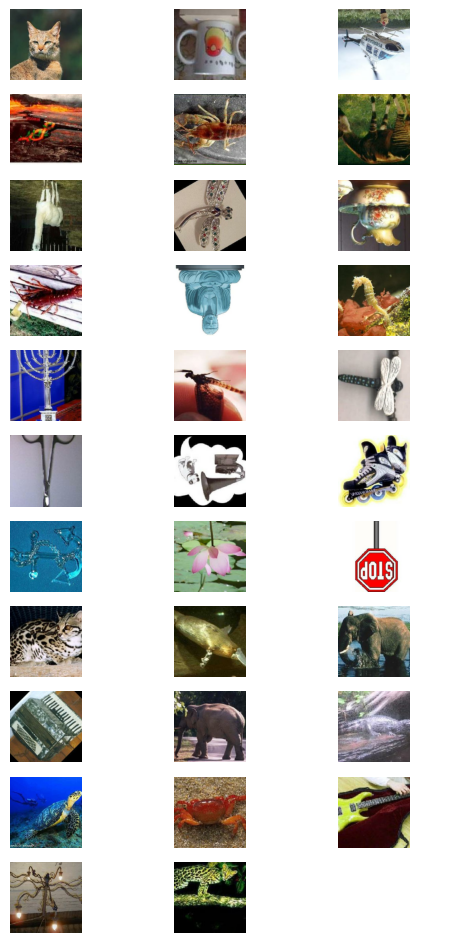

In [ ]:
random_flip = keras.layers.RandomFlip()
augmenters += [random_flip]

image_batch = random_flip(image_batch)
plot_image_gallery(
    image_batch
)

Half of the images have been flipped!

The next augmentation we'll use is `RandomCrop`.
This operation selects a random subset of the image.
By using this augmentation, we force our classifier to become spatially invariant.

Let's add a `RandomCrop` to our set of augmentations:

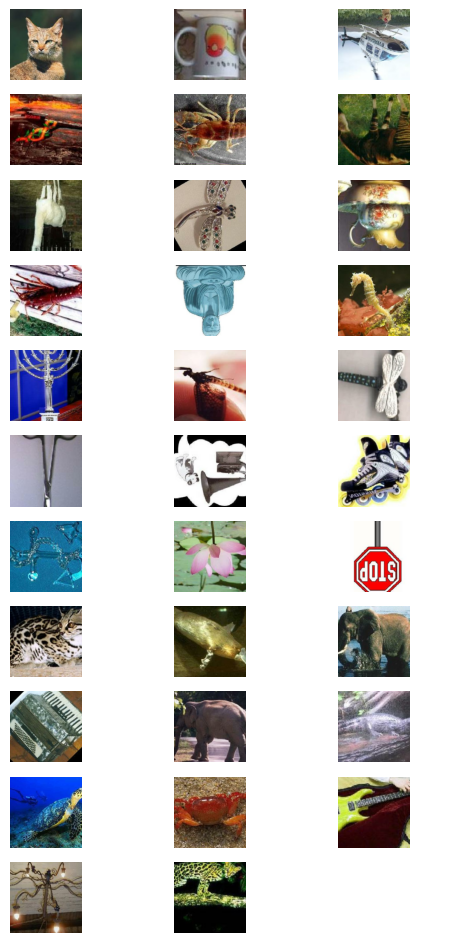

In [ ]:
crop = keras.layers.RandomCrop(
    int(IMAGE_SIZE[0]*0.9),
    int(IMAGE_SIZE[1]*0.9),
)

augmenters += [crop]

image_batch = crop(image_batch)
plot_image_gallery(
    image_batch,
)

We can also rotate images by a random angle using Keras' `RandomRotation` layer. Let's apply a rotation by a randomly selected angle in the interval -45°...45°:

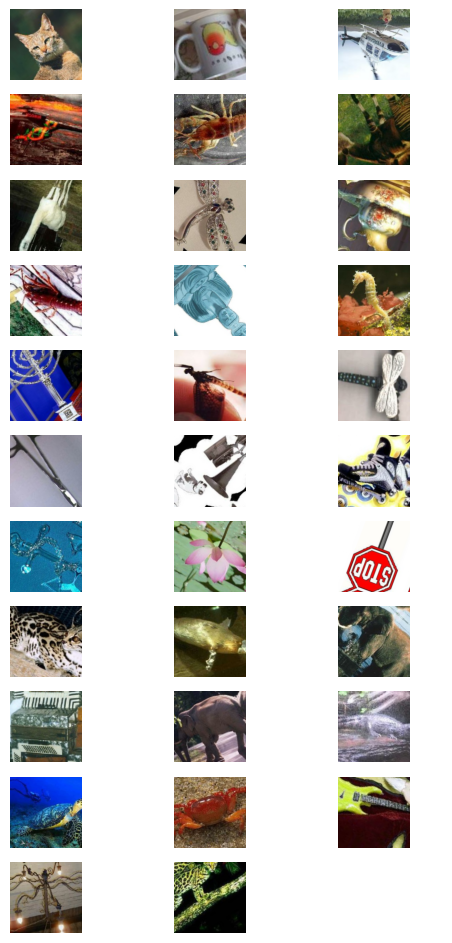

In [ ]:
rotate = keras.layers.RandomRotation(
    (-45/360, 45/360)
)

augmenters += [rotate]

image_batch = rotate(image_batch)
plot_image_gallery(
    image_batch
)

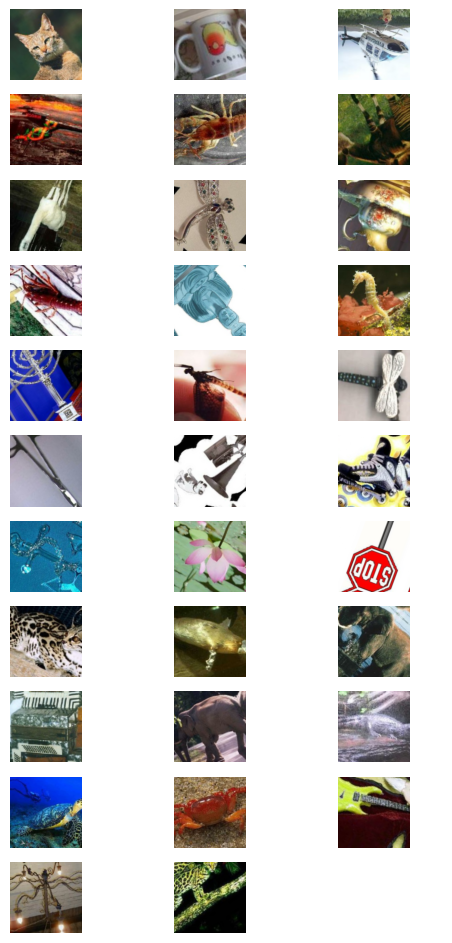

In [ ]:
resize = keras.layers.Resizing(*IMAGE_SIZE, crop_to_aspect_ratio=True)
augmenters += [resize]

image_batch = resize(image_batch)
plot_image_gallery(
    image_batch
)

Now let's apply our final augmenter to the training data:

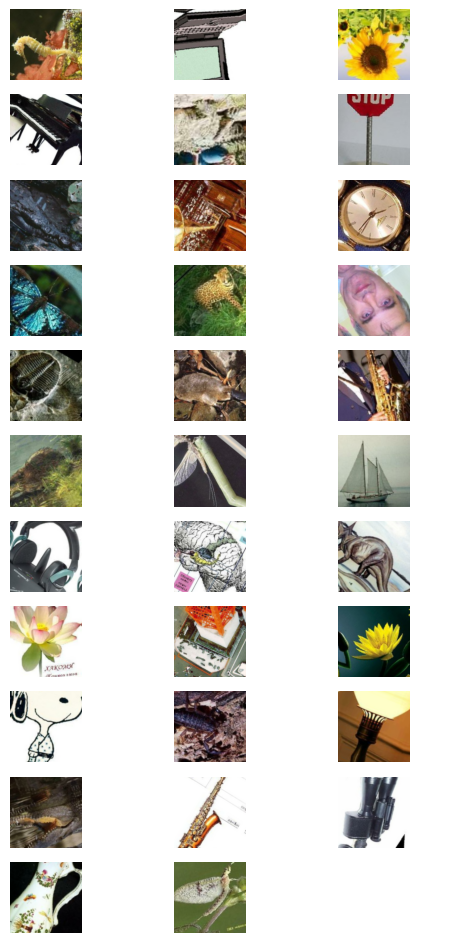

In [ ]:

def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs["images"] = augmenter(inputs["images"])
        return inputs

    return augmenter_fn

augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(train_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

We also need to resize our evaluation set to get dense batches of the image size
expected by our model. We directly use the deterministic `keras.layers.Resizing` in
this case to avoid adding noise to our evaluation metric due to applying random augmentations.

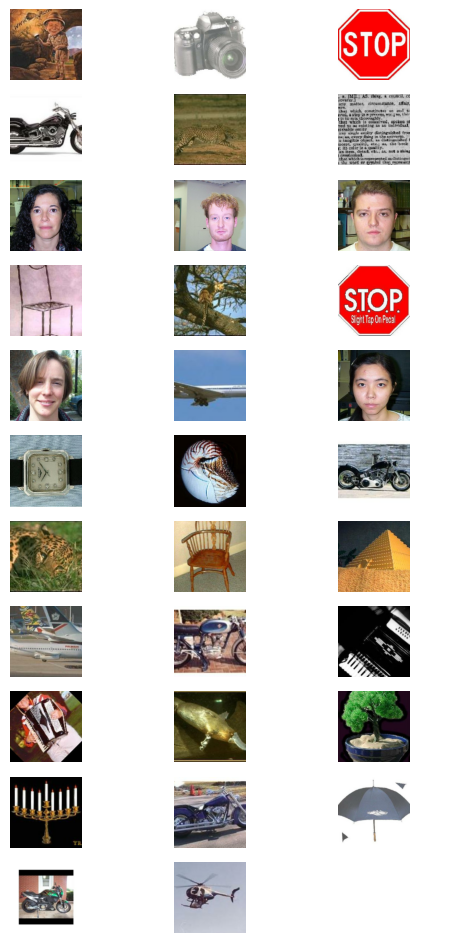

In [ ]:
inference_resizing = keras.layers.Resizing(
    *IMAGE_SIZE, crop_to_aspect_ratio=True
)
def do_resize(inputs):
    inputs['images'] = inference_resizing(inputs['images'])
    return inputs

eval_ds = eval_ds.map(do_resize, num_parallel_calls=tf.data.AUTOTUNE)

image_batch = next(iter(eval_ds.take(1)))["images"]
plot_image_gallery(
    image_batch,
)

Finally, lets unpackage our datasets and prepare to pass them to `model.fit()`,
which accepts a tuple of `(images, labels)`.

In [ ]:
def unpackage_dict(inputs):
    return inputs["images"], inputs["labels"]

train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

Data augmentation is by far the hardest piece of training a modern
classifier.
Congratulations on making it this far!

### Optimizer Tuning

To achieve optimal performance, we need to use a learning rate schedule instead
of a single learning rate. While we won't go into detail on the Cosine decay
with warmup schedule used here, [you can read more about it
here](https://scorrea92.medium.com/cosine-learning-rate-decay-e8b50aa455b).

In [ ]:

def lr_warmup_cosine_decay(
    global_step,
    warmup_steps,
    hold=0,
    total_steps=0,
    start_lr=0.0,
    target_lr=1e-2,
):
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


class WarmUpCosineDecay(schedules.LearningRateSchedule):
    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)


![WarmUpCosineDecay schedule](https://i.imgur.com/YCr5pII.png)

The schedule looks a as we expect.

Next let's construct this optimizer:

In [ ]:
total_images = 9000
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)
optimizer = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

At long last, we can now build our model and call `fit()`!
Here, we directly instantiate our `ResNetBackbone`, specifying all architectural parameters, which gives us full control to tweak the architecture.

In [ ]:
backbone = keras_hub.models.ResNetBackbone(
    input_conv_filters=[64],
    input_conv_kernel_sizes=[7],
    stackwise_num_filters=[64, 64, 64],
    stackwise_num_blocks=[2,2,2],
    stackwise_num_strides=[1,2,2],
    block_type="basic_block"
)
model = keras.Sequential(
    [
        backbone,
        keras.layers.GlobalMaxPooling2D(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(101, activation="softmax"),
    ]
)

We employ label smoothing to prevent the model from overfitting to artifacts of
our augmentation process.

In [ ]:
loss = losses.CategoricalCrossentropy(label_smoothing=0.1)

Let's compile our model:

In [ ]:
model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=[
        metrics.CategoricalAccuracy(),
        metrics.TopKCategoricalAccuracy(k=5),
    ],
)

and finally call fit().

In [ ]:
model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=eval_ds,
)

96/96 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - categorical_accuracy: 0.0156 - loss: 4.8529 - top_k_categorical_accuracy: 0.0721 - val_categorical_accuracy: 0.0151 - val_loss: 4.7209 - val_top_k_categorical_accuracy: 0.1292


Congratulations!  You now know how to train a powerful image classifier from
scratch using KerasHub.
Depending on the availability of labeled data for your application, training
from scratch may or may not be more powerful than using transfer learning in
addition to the data augmentations discussed above. For smaller datasets,
pretrained models generally produce high accuracy and faster convergence.

## Conclusions

While image classification is perhaps the simplest problem in computer vision,
the modern landscape has numerous complex components.
Luckily, KerasHub offers robust, production-grade APIs to make assembling most
of these components possible in one line of code.
Through the use of KerasHub's `ImageClassifier` API, pretrained weights, and
Keras' data augmentations you can assemble everything you need to train a
powerful classifier in a few hundred lines of code!

As a follow up exercise, try fine tuning a KerasHub classifier on your own dataset!